In [93]:
from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json

seed = 12345678

In [94]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [95]:
def make_loaders(args, test=False):
    if test:
        test_dataset = DataClass(args, args['test_path'])
        test_data_loader = DataLoader(test_dataset,
                                    batch_size=int(args['test_batch_size']),
                                    shuffle=False)
        print('The number of Test batches: ', len(test_data_loader))

        return test_data_loader
    else:
        train_dataset = DataClass(args, args['train_path'])
        train_data_loader = DataLoader(train_dataset,
                                    batch_size=int(args['train_batch_size']),
                                    shuffle=True
                                    )
        print('The number of training batches: ', len(train_data_loader))

        val_dataset = DataClass(args, args['val_path'])
        val_data_loader = DataLoader(val_dataset,
                                    batch_size=int(args['val_batch_size']),
                                    shuffle=False
                                    )
        print('The number of validation batches: ', len(val_data_loader))

        return train_data_loader, val_data_loader

In [96]:
def make_model(args):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'],
                    joint_loss=args['loss_type'],
                    alpha=args['alpha_loss'])
    
    return model


In [97]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    if loaders is None:
        train_data_loader, val_data_loader = make_loaders(args)
    else:
        train_data_loader, val_data_loader = loaders
    model = make_model(args)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [98]:
hyperparams = {
    'train_path':'data/train.csv', 
    'val_path':'data/val.csv',
    'backbone':'bert-base-uncased',
    'train_batch_size': 128,
    'val_batch_size': 128,
    'output_dropout': 0.1,
    'loss_type': 'joint',
    'alpha_loss': 0.2,
    'max_epoch': 20,
    'max_length': 128,
    'ffn_lr': 0.001,
    'bert_lr': 2e-5
}

In [99]:
# tuning = {
#     'train_batch_size': [64, 128, 256],
#     'output_dropout': [0.05, 0.1, 0.15],
#     'loss_type': ['joint', 'cross-entropy', 'corr_loss'],
#     'ffn_lr': 0.001,
#     'bert_lr': 2e-5

# }

In [100]:
assert False

AssertionError: 

## Train

In [ ]:
loaders = make_loaders(hyperparams)

/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 43410/43410 [00:38<00:00, 1124.24it/s]


The number of training batches:  340
Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 5426/5426 [00:05<00:00, 1070.88it/s]

The number of validation batches:  43


In [ ]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future vers

Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time
0.2972,0.2029,0.4543,0.5770,0.5264,03:00
0.2017,0.1913,0.5222,0.6117,0.5689,02:52
0.1893,0.1901,0.5401,0.6060,0.5664,02:50
0.1814,0.1870,0.5383,0.6198,0.5806,03:01
0.1746,0.1888,0.5416,0.6155,0.5772,02:53
0.1671,0.1938,0.5414,0.6123,0.5776,02:46
0.1592,0.1989,0.5282,0.5962,0.5603,02:47
0.1513,0.2073,0.5269,0.5764,0.5418,02:46


epoch#:  1
Validation loss decreased (inf --> 0.202950).  Saving model ...
epoch#:  2
Validation loss decreased (0.202950 --> 0.191286).  Saving model ...
epoch#:  3
Validation loss decreased (0.191286 --> 0.190111).  Saving model ...
epoch#:  4
Validation loss decreased (0.190111 --> 0.187024).  Saving model ...
epoch#:  5
EarlyStopping counter: 1 out of 5
epoch#:  6
EarlyStopping counter: 2 out of 5
epoch#:  7
EarlyStopping counter: 3 out of 5
epoch#:  8
EarlyStopping counter: 4 out of 5
epoch#:  9
EarlyStopping counter: 5 out of 5
Early stopping


## Test

In [101]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device)

In [102]:
hyperparams['test_path'] = 'data/test.csv'
hyperparams['test_batch_size'] = 128

In [103]:
test_loader = make_loaders(hyperparams, test=True)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 5427/5427 [00:04<00:00, 1095.28it/s]

The number of Test batches:  43


In [104]:
preds = test(hyperparams, "2023-11-22-18:43:46_checkpoint.pt", loader=test_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.5288 F1-Micro: 0.6254 JS: 0.5850 Time: 00:07


In [105]:
print("Macro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="macro"))
print("Micro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="micro"))

Macro AUC: 0.9420511822201457
Micro AUC: 0.9650044933547238


In [112]:
import matplotlib.pyplot as plt

In [120]:
sum(roc_auc_score(preds["y_true"], preds["logits"], average=None))/28

0.9420511822201457

In [124]:
fpr, tpr, _ = roc_curve(preds["y_true"].flatten(), preds["logits"].flatten())

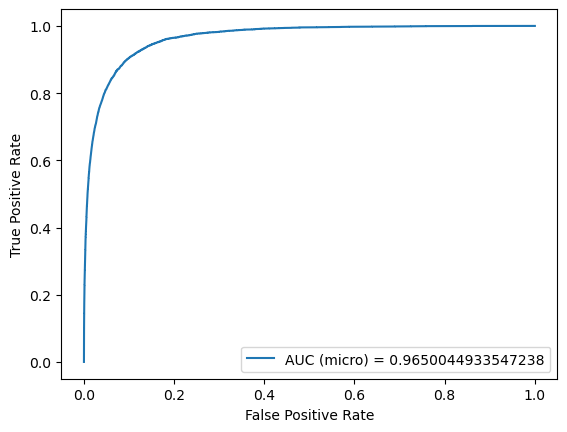

In [126]:
plt.plot(fpr, tpr, label="AUC (micro) = 0.9650044933547238")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)


In [ ]:
from sklearn.metrics import f1_score, jaccard_score

In [ ]:
for t in range(11):
    t = t/10

    probs = 1/(1+np.exp(-preds['logits'])) > t
    y_true = preds['y_true']

    print(f1_score(y_true, probs, average="macro"), end="\t")
    print(f1_score(y_true, probs, average="micro"), end="\t")
    print(jaccard_score(y_true, probs, average="samples"))


0.07482442019603729	0.07996967495340683	0.04165021453578666
0.47552662552344044	0.5117655481838576	0.44146068598804916
0.5151212647450673	0.56479928435648	0.5058183509261452
0.527761117077311	0.5963136519837551	0.5458356366316566
0.5357165785087318	0.6130976846143308	0.5701369694736196
0.5288248239687553	0.6253621573434366	0.5849886370616056
0.5105963277245295	0.6263851815902289	0.5819482832749832
0.4867413904674384	0.6135197310210582	0.554588170259812
0.43579505432281096	0.57196261682243	0.4828788157975555
0.30943826055121215	0.46990819449166943	0.3502088323813034
0.0	0.0	0.0


In [ ]:
model = make_model(hyperparams)
model.load_state_dict(torch.load("models/2023-11-22-18:43:46_checkpoint.pt"))
model.to(device)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SpanEmo(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
dc = DataClass(hyperparams, ["ohhh i see"], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


PreProcessing dataset ...: 100%|██████████| 1/1 [00:00<00:00, 937.69it/s]


In [ ]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[0]

label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

for i in range(28):
    print(f"{probs[i]:.3f}", label_names[i])

0.002 admiration
0.001 amusement
0.001 anger
0.003 annoyance
0.014 approval
0.000 caring
0.001 confusion
0.001 curiosity
0.000 desire
0.001 disappointment
0.001 disapproval
0.001 disgust
0.001 embarrassment
0.034 excitement
0.000 fear
0.001 gratitude
0.000 grief
0.005 joy
0.000 love
0.000 nervous
0.001 optimism
0.000 pride
0.041 realization
0.001 relief
0.000 remorse
0.000 sadness
0.546 surprise
0.926 neutral


In [116]:
label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

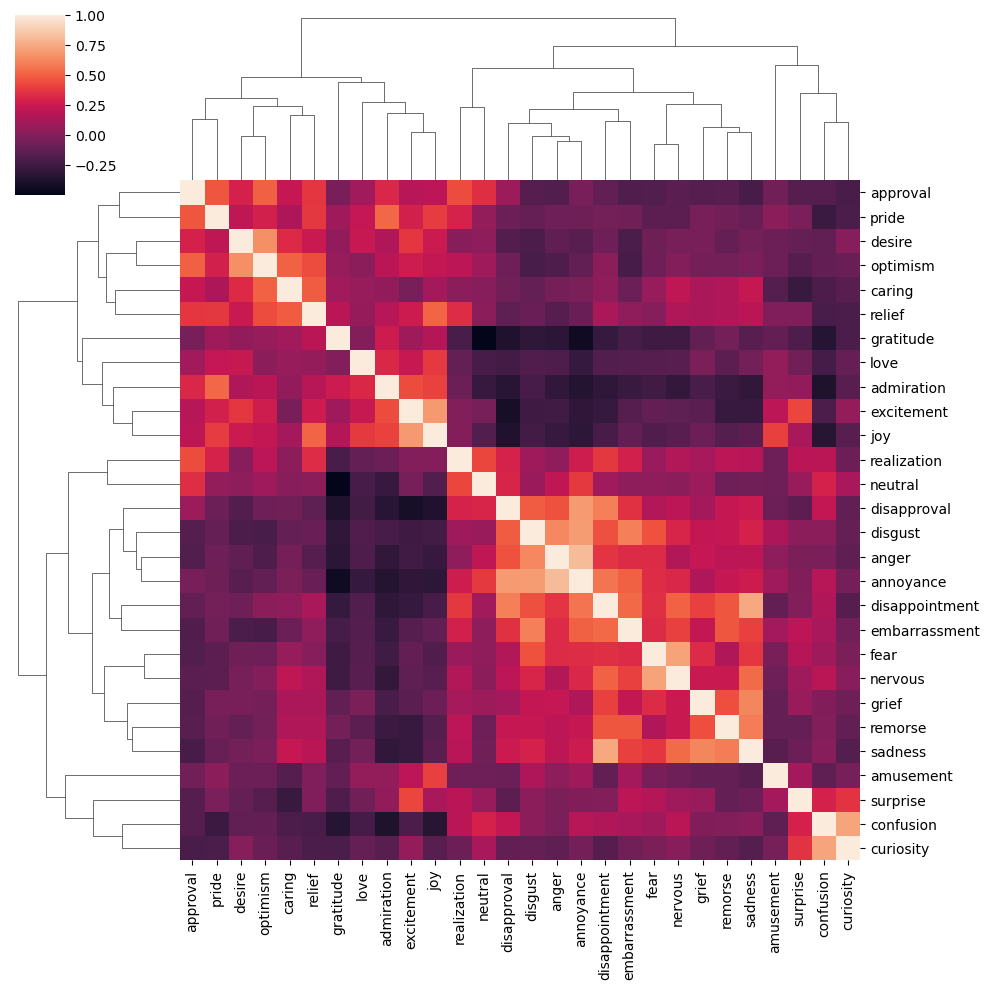

In [117]:
_ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]